<a href="https://colab.research.google.com/github/datle2403/datle2403/blob/main/Predicting_Continuous_Target_Variables_with_Regression_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Chapter outline:
>Exploring and visualizing datasets

>Looking at different approaches to implement linear regression models

>Training regression models that are robust to outliers

>Evaluating regression models and diagnosing common problems

>regression models to nonlinear data


The vertical offset from regression line to training ex caled residual


In [6]:
import pandas as pd
df=pd.read_csv('housing_boston_price.csv',header=0,delimiter=',')

In [7]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


#EDA


In [8]:
!pip install mlxtend

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
df.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV'],
      dtype='object')

(<Figure size 720x576 with 25 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa6c7a541d0>,
       dtype=object))

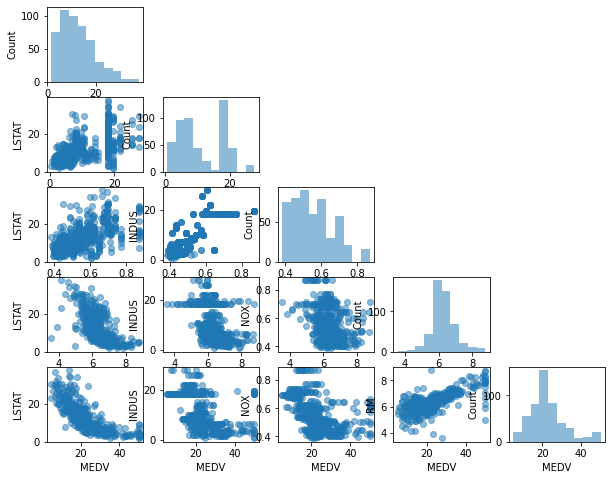

In [10]:

import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix
cols=['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']
scatterplotmatrix(df[cols].values,names=cols,alpha=0.5,figsize=(10,8))


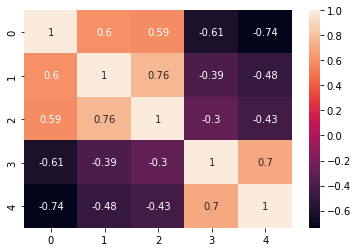

In [11]:
import numpy as np
import seaborn as sns
cm = np.corrcoef(df[cols].values.T)
hm = sns.heatmap(cm,annot=cm)


In [12]:
class LinearRegressionGD(object):

    def __init__(self, eta=0.001, n_iter=20):
        self.eta = eta
        self.n_iter = n_iter

    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []

        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors**2).sum() / 2.0
            self.cost_.append(cost)
        return self

    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def predict(self, X):
        return self.net_input(X)

In [18]:
X = df[['RM']].values
y = df['MEDV'].values
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()
X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten() 
# without flatten, return 2-dim array

In [19]:
y_std.shape

(506,)

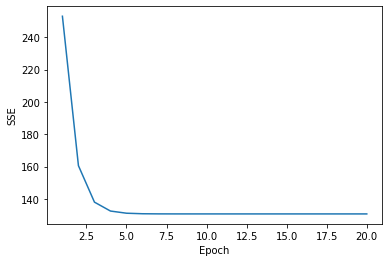

In [20]:
lr = LinearRegressionGD()
lr.fit(X_std, y_std)
plt.plot(range(1, lr.n_iter+1), lr.cost_)
plt.ylabel('SSE')
plt.xlabel('Epoch')
#plt.tight_layout()
#plt.savefig('images/10_05.png', dpi=300)
plt.show()

Text(0, 0.5, 'Price in $1000s [MEDV] (standardized)')

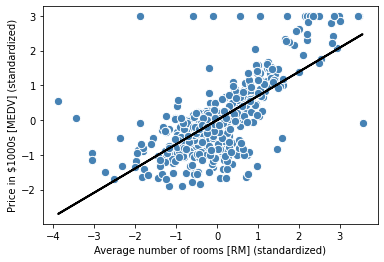

In [21]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, model.predict(X), color='black', lw=2)    
    return 
lin_regplot(X_std, y_std, lr)
plt.xlabel('Average number of rooms [RM] (standardized)')
plt.ylabel('Price in $1000s [MEDV] (standardized)')

In [22]:
from distutils.version import LooseVersion
import sklearn


num_rooms_std = sc_x.transform(np.array([[5.0]]))
price_std = lr.predict(num_rooms_std)

if LooseVersion(sklearn.__version__) >= LooseVersion('0.23.0'):
    print("Price in $1000s: %.3f" % sc_y.inverse_transform(price_std[:, np.newaxis]).flatten())
else:
    print("Price in $1000s: %.3f" % sc_y.inverse_transform(price_std))

Price in $1000s: 10.840


As a side note, it is also worth mentioning that we technically don't have to update the weights of the intercept if we are working with standardized variables, since the y axis intercept is always 0 in those cases. We can quickly confirm this by printing the weights:

In [23]:
print('Slope: %.3f' % lr.w_[1])
print('Intercept: %.3f' % lr.w_[0])

Slope: 0.695
Intercept: -0.000


In [24]:
from sklearn.linear_model import LinearRegression
slr = LinearRegression()
slr.fit(X, y)
y_pred = slr.predict(X)
print('Slope: %.3f' % slr.coef_[0])
print('Intercept: %.3f' % slr.intercept_)

Slope: 9.102
Intercept: -34.671


Text(0, 0.5, 'Price in $1000s [MEDV]')

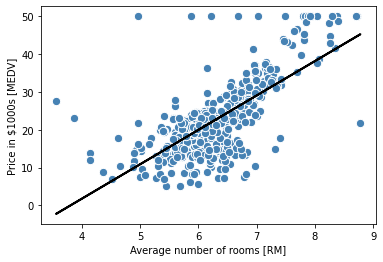

In [25]:
lin_regplot(X, y, slr)
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000s [MEDV]')

# Using RANSAC to eliminate outliers


1. Select a random number of examples to be inliers and fit the model.
2. Test all other data points against the fi ed model and add those points that fall within a user-given tolerance to the inliers.
3. Refit the model using all inliers.
4. Estimate the error of the fi ed model versus the inliers.
5. Terminate the algorithm if the performance meets a certain user- defined threshold or if a fixed number of iterations were reached; go back to step 1 otherwise.

In [26]:
from sklearn.linear_model import RANSACRegressor
ransac=RANSACRegressor(LinearRegression(), max_trials=100,min_samples=50,loss='absolute_loss',residual_threshold=8.0, random_state=0)
ransac.fit(X,y)


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ransac.py:358: FutureWarning: The loss 'absolute_loss' was deprecated in v1.0 and will be removed in version 1.2. Use `loss='absolute_error'` which is equivalent.
  FutureWarning,


RANSACRegressor(base_estimator=LinearRegression(), loss='absolute_loss',
                min_samples=50, random_state=0, residual_threshold=8.0)

By default, scikit-learn uses the MAD estimate to select the inlier threshold, where MAD stands for the median absolute deviation of the target values, y . However, the choice of an appropriate value for the inlier threshold is problem-specific, which is one disadvantage of RANSAC.

In [27]:
inlier_mask=ransac.inlier_mask_

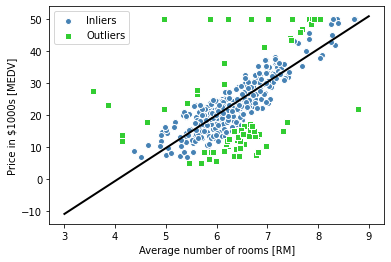

In [28]:
outlier_mask = np.logical_not(inlier_mask)

line_X = np.arange(3, 10, 1)
line_y_ransac = ransac.predict(line_X[:, np.newaxis])
plt.scatter(X[inlier_mask], y[inlier_mask],
            c='steelblue', edgecolor='white', 
            marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='limegreen', edgecolor='white', 
            marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='black', lw=2)   
plt.xlabel('Average number of rooms [RM]')
plt.ylabel('Price in $1000s [MEDV]')
plt.legend(loc='upper left')

In [29]:
print('Slope: %.3f' % ransac.estimator_.coef_[0])
print('Intercept: %.3f' % ransac.estimator_.intercept_)

Slope: 10.280
Intercept: -41.750


#Evaluating the performance of linear regression models

In [30]:
from sklearn.model_selection import train_test_split
X = df.iloc[:, :-1].values
y = df['MEDV'].values
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3, random_state=0)

In [31]:
X.shape

(506, 13)

In [32]:
slr = LinearRegression()

slr.fit(X_train, y_train)
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

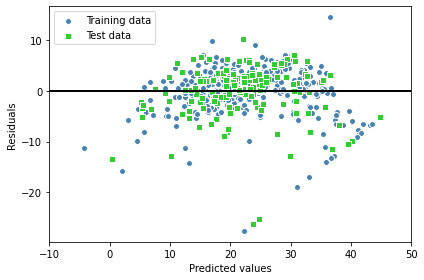

In [33]:
plt.scatter(y_train_pred,  y_train_pred - y_train,
            c='steelblue', marker='o', edgecolor='white',
            label='Training data')
plt.scatter(y_test_pred,  y_test_pred - y_test,
            c='limegreen', marker='s', edgecolor='white',
            label='Test data')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, color='black', lw=2)
plt.xlim([-10, 50])
plt.tight_layout()

The MSE is useful for comparing different regression models or for tuning their parameters via grid search and cross-validation, as it normalizes the SSE by the sample size:

However, please be aware that the MSE is unbounded in contrast to the classification accuracy,

coefficient of determination (R^2): standardize version of MSE

In [34]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 19.958, test: 27.196
R^2 train: 0.765, test: 0.673


# Using regularized methods for regression

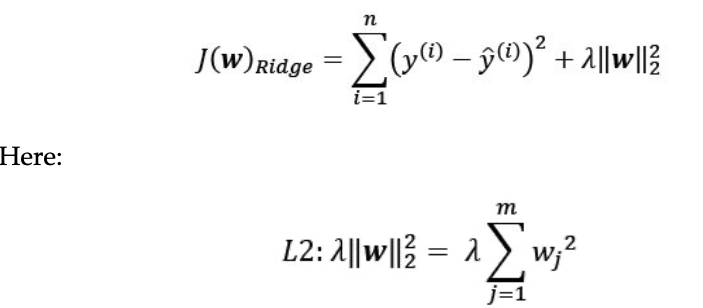

Ridge regression (L2): 
LASSO(L1): make unuse weight to 0
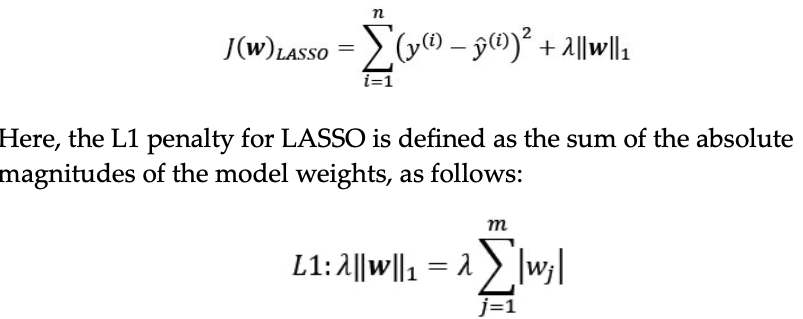

However, a limitation of LASSO is that it selects at most n features if m > n, where n is the number of training examples. This may be undesirable in certain applications of feature selection. In practice, however, this property of LASSO is often an advantage because it avoids saturated models. 

Saturation of a model occurs if the number of training examples is equal to the number of features

a saturated model can always fit the training data perfectly but is merely a form of interpolation and thus is not expected to generalize well.

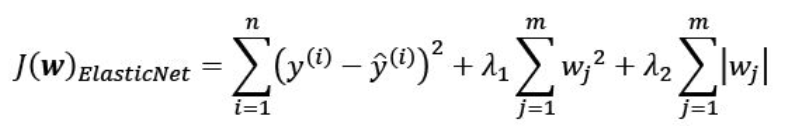

In [35]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)
print(lasso.coef_)

[-0.11311792  0.04725111 -0.03992527  0.96478874 -0.          3.72289616
 -0.02143106 -1.23370405  0.20469    -0.0129439  -0.85269025  0.00795847
 -0.52392362]


In [36]:
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 20.926, test: 28.876
R^2 train: 0.753, test: 0.653


In [37]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1.0)


from sklearn.linear_model import Lasso
lasso = Lasso(alpha=1.0)


from sklearn.linear_model import ElasticNet
elanet = ElasticNet(alpha=1.0, l1_ratio=0.5)

#Adding polynomial terms using scikit-learn

In [38]:
X = np.array([258.0, 270.0, 294.0, 
              320.0, 342.0, 368.0, 
              396.0, 446.0, 480.0, 586.0])\
             [:, np.newaxis]

y = np.array([236.4, 234.4, 252.8, 
              298.6, 314.2, 342.2, 
              360.8, 368.0, 391.2,
              390.8])
from sklearn.preprocessing import PolynomialFeatures

lr = LinearRegression()
pr = LinearRegression()
quadratic = PolynomialFeatures(degree=2)
X_quad = quadratic.fit_transform(X)
# fit linear features
lr.fit(X, y)
X_fit = np.arange(250, 600, 10)[:, np.newaxis]
y_lin_fit = lr.predict(X_fit)

# fit quadratic features
pr.fit(X_quad, y)
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))


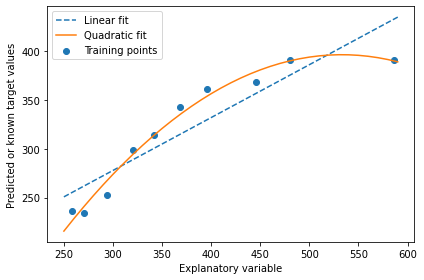

In [39]:
# plot results
plt.scatter(X, y, label='Training points')
plt.plot(X_fit, y_lin_fit, label='Linear fit', linestyle='--')
plt.plot(X_fit, y_quad_fit, label='Quadratic fit')
plt.xlabel('Explanatory variable')
plt.ylabel('Predicted or known target values')
plt.legend(loc='upper left')

plt.tight_layout()
#plt.savefig('images/10_11.png', dpi=300)
plt.show()

In [40]:
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)
print('Training MSE linear: %.3f, quadratic: %.3f' % (
        mean_squared_error(y, y_lin_pred),
        mean_squared_error(y, y_quad_pred)))
print('Training R^2 linear: %.3f, quadratic: %.3f' % (
        r2_score(y, y_lin_pred),
        r2_score(y, y_quad_pred)))

Training MSE linear: 569.780, quadratic: 61.330
Training R^2 linear: 0.832, quadratic: 0.982



# Modeling nonlinear relationships in the Housing Dataset

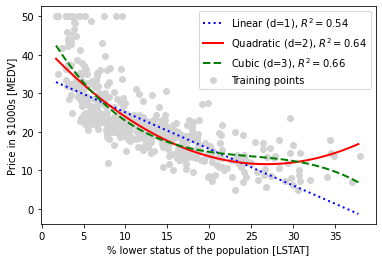

In [41]:
X = df[['LSTAT']].values
y = df['MEDV'].values

regr = LinearRegression()

# create quadratic features
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

# fit features
X_fit = np.arange(X.min(), X.max(), 1)[:, np.newaxis]

regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))


# plot results
plt.scatter(X, y, label='Training points', color='lightgray')

plt.plot(X_fit, y_lin_fit, 
         label='Linear (d=1), $R^2=%.2f$' % linear_r2, 
         color='blue', 
         lw=2, 
         linestyle=':')

plt.plot(X_fit, y_quad_fit, 
         label='Quadratic (d=2), $R^2=%.2f$' % quadratic_r2,
         color='red', 
         lw=2,
         linestyle='-')

plt.plot(X_fit, y_cubic_fit, 
         label='Cubic (d=3), $R^2=%.2f$' % cubic_r2,
         color='green', 
         lw=2, 
         linestyle='--')

plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000s [MEDV]')
plt.legend(loc='upper right')

#plt.savefig('images/10_12.png', dpi=300)
plt.show()

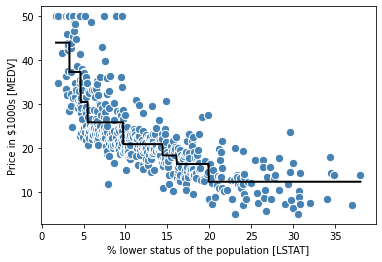

In [42]:
from sklearn.tree import DecisionTreeRegressor

X = df[['LSTAT']].values
y = df['MEDV'].values

tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)

sort_idx = X.flatten().argsort()

lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000s [MEDV]')
#plt.savefig('images/10_14.png', dpi=300)
plt.show()

In [43]:
X = df.iloc[:, :-1].values
y = df['MEDV'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=1)
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_estimators=1000, 
                               criterion='mse', 
                               random_state=1, 
                               n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


MSE train: 1.644, test: 11.085
R^2 train: 0.979, test: 0.877
